#**Deep Reinforcement Learning**

##Submitted by: Franch Lee D. Bataan

---



In [1]:
#Installing libraries needed 
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra] 
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:13:01tcmalloc: large alloc 1147494400 bytes == 0x38cec000 @  0x7fd13f8d1615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |██████████████████▌             | 1055.7 MB 1.4 MB/s eta 0:09:20tcmalloc: large alloc 1434370048 bytes == 0x7d342000 @  0x7fd13f8d1615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     

##Importing Libraries

In [3]:
import os
import io
import base64
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import HTML

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')# Base Grame Creation
env = JoypadSpace(env, SIMPLE_MOVEMENT) # For simplifying the controls
env = GrayScaleObservation(env, keep_dim=True) # Grayscale
env = DummyVecEnv([lambda: env]) #Wrap inside the Dummy Environment
env = VecFrameStack(env, 4, channels_order='last') # Stacking the frames

In [5]:
state=env.reset()

In [6]:
state.shape

(1, 240, 256, 4)

In [7]:
state, reward, done, info = env.step([5])

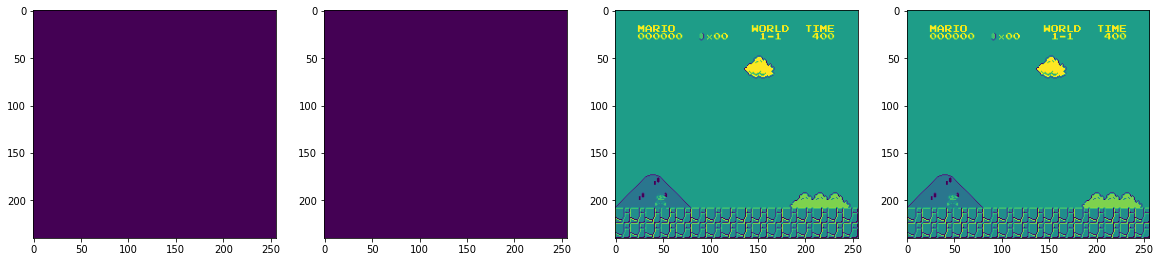

In [8]:
#Visualization of movement
plt.figure(figsize=(20,6))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

##Building the model



In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [8]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
#saving the model for every 20000 steps
callback = TrainAndLoggingCallback(check_freq=20000, save_path=CHECKPOINT_DIR)

##Training

In [9]:
# This is where the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [10]:
# training the model with 500000 timesteps
model.learn(total_timesteps=500000, callback=callback)

Logging to ./logs/PPO_2


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 5008          |
|    total_timesteps      | 358400        |
| train/                  |               |
|    approx_kl            | 1.9788044e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.924        |
|    explained_variance   | -0.147        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0889        |
|    n_updates            | 6990          |
|    policy_gradient_loss | 3.07e-05      |
|    value_loss           | 0.164         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 71            |
|    iterations           | 701           |
|    time_elapsed         | 5016          |
|    total_timesteps      | 358912        |
| train/                  |               |
|    approx_kl           

In [11]:
#Saving the model
model.save('Mario_model')

In [12]:
# Loading model
model = PPO.load('./train/best_model_500000')

In [10]:
import gym
from gym import wrappers

In [21]:
# Setup game
import gym
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(4000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

Exception ignored in: <function Monitor.__del__ at 0x7fa3967d7d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 289, in __del__
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 178, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/nes_py/nes_env.py", line 346, in close
ValueError: env has already been closed.
/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


##1 Minute Video

In [22]:
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="480" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

##Discussion

The output provided by the model was able to learn and play the Super Mario Game. In the video, the AI was able to overcome some enemies at the start and make it pass to the first pipe. However, as soon as it reached the second pipe, the AI makes it hard to overcome the obstacles and takes a longer time before it learned to jump higher to past the obstacle which we will see at the second video with much longer time frame. 


In [11]:
model = PPO.load('./train/best_model_500000')
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(20000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="480" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Here, the AI was able to overcome the obstacle as it performs long jump. But as soon as it reaches to a much bigger pipe, it failed to past the bigger pipe and the AI started playing at the beginning again. 

##Conclusion

In conclusion, the model is trained with five hundred thousand timesteps and after hours of training the model, I was able to create a program that can play super Mario and survive for four minutes before it restarted again. For improving the performance, we can train the model for longer with a slow learning rate. Increasing the number of timesteps allows the AI to learn better and survived for a much longer time but it would also take a longer time to train the model. This helps the model learn many components and improves its gameplay over time. But as we train the model for much further timesteps, you need to have a pc or working environment that has a lot of storage on it for saving the model as it takes almost 275 MB for every twenty thousand timesteps in my program. 
 
In this activity, I was able to learn how to apply reinforcement learning by creating a program that can play itself and survive for a certain timeframe. I learned different techniques which allow me to apply them in the program but there are some other things that I have difficulty processing and understanding. Overall, I enjoyed working on this activity even though it took me 6 hours to finish the program. 
